# Inflation Hedging Analysis

This code is a comprehensive gold price analysis tool that examines the relationship between gold prices and inflation (CPI data). 

In this analysis, I examined the relationship between gold prices and inflation by comparing historical gold price trends to Consumer Price Index (CPI) data. Our goal was to determine whether gold serves as an effective hedge against inflation.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data as pdr
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('ggplot')  # Changed from 'seaborn' to 'ggplot'
sns.set_style("whitegrid")  # Set seaborn style
sns.set_palette("husl")

The GoldAnalysis class is designed to analyze gold’s role as an inflation hedge by comparing gold price trends to CPI (Consumer Price Index) data.

This class: 

- Loads & cleans gold price & CPI data
- Computes inflation rates & gold returns
- Merges datasets for analysis
- Visualizes trends & correlations
- Computes inflation beta (gold’s hedging effectiveness)

In [3]:
class GoldAnalysis:
    def __init__(self):
        self.daily = None
        self.monthly = None
        self.quarterly = None
        self.cpi_data = None
        
    def load_gold_data(self):
        """Load and clean gold price datasets"""
        try:
            # Load raw data
            daily_df = pd.read_csv('gold_data/Daily_Gold_Price_on_World.csv')
            monthly_df = pd.read_csv('gold_data/Monthly_Gold_Price_on_World.csv')
            quarterly_df = pd.read_csv('gold_data/Quarterly_Gold_Price_on_World.csv')
            
            # Clean datasets
            self.daily = self._clean_dataset(daily_df, 'D')
            self.monthly = self._clean_dataset(monthly_df, 'M')
            self.quarterly = self._clean_dataset(quarterly_df, 'Q')
            
        except Exception as e:
            print(f"Error loading gold data: {e}")
            self._create_fallback_data()
    
    def _clean_dataset(self, df, freq):
        """Helper method to clean individual dataset"""
        df = df.copy()
        
        # Standardize column names
        df.columns = [str(col).strip().replace(' ', '_').replace('(', '').replace(')', '').lower() 
                     for col in df.columns]
        
        # Fix specific column names
        rename_map = {
            'thai_baht_thb': 'thai_baht',
            'japanese_yen_jpy': 'jpy',
            'us_dollar_usd': 'usd',
            'euro_eur': 'eur',
            'pound_sterling_gbp': 'gbp'
        }
        df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})
        
        # Convert and set date index
        if freq == 'Q':
            df['date'] = pd.to_datetime(df['date'].str.replace(r'Q(\d) (\d{4})', r'\2-\1', regex=True))
        else:
            df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        
        # Handle missing values
        price_cols = [col for col in df.columns if col != 'date']
        df[price_cols] = df[price_cols].replace(0, np.nan).ffill(limit=30)
        
        return df
    
    def _create_fallback_data(self):
        """Create synthetic data if loading fails"""
        print("Creating fallback data...")
        dates = pd.date_range(start='2000-01-01', periods=1000, freq='D')
        self.daily = pd.DataFrame({
            'usd': np.cumprod(1 + np.random.normal(0.0005, 0.01, len(dates))) * 300,
            'eur': np.random.uniform(0.8, 0.9, len(dates)),
            'jpy': np.random.uniform(100, 110, len(dates))
        }, index=dates)
        
        self.monthly = self.daily.resample('M').last()
        self.quarterly = self.daily.resample('Q').last()
    
    def add_features(self, df, freq):
        """Add time-series features to dataframe"""
        if df is None:
            return None
            
        df = df.copy()
        
        # Basic features
        df['return'] = df['usd'].pct_change()
        
        # Window features
        windows = {'D': [7, 30, 90], 'M': [3, 6, 12], 'Q': [2, 4, 8]}[freq]
        for w in windows:
            df[f'ma_{w}'] = df['usd'].rolling(w).mean()
            df[f'volatility_{w}'] = df['return'].rolling(w).std()
        
        # Lag features
        for lag in [1, 2, 3, 5, 7]:
            df[f'lag_{lag}'] = df['usd'].shift(lag)
        
        return df.dropna()
    
    def get_cpi_data(self, api_key=None):
        """Load CPI data from FRED"""
        try:
            if api_key:
                pdr.fred.FREDReader.api_key = api_key
            
            cpi = pdr.get_data_fred('CPIAUCSL', start='2000-01-01')
            cpi_daily = cpi.resample('D').ffill()
            cpi_daily['inflation_rate'] = cpi_daily['CPIAUCSL'].pct_change(12) * 100
            
            self.cpi_data = cpi_daily.rename(columns={'CPIAUCSL': 'cpi'})
            
        except Exception as e:
            print(f"Error getting CPI data: {e}")
            self._create_fallback_cpi()
    
    def _create_fallback_cpi(self):
        """Create synthetic CPI data if loading fails"""
        print("Creating fallback CPI data...")
        if self.daily is None:
            return
            
        self.cpi_data = pd.DataFrame({
            'cpi': np.linspace(170, 270, len(self.daily))},
            index=self.daily.index)
        self.cpi_data['inflation_rate'] = self.cpi_data['cpi'].pct_change(12) * 100
    
    def merge_data(self):
        """Merge gold and CPI data"""
        if self.daily is None or self.cpi_data is None:
            return None
            
        merged = pd.merge(
            self.daily[['usd']], 
            self.cpi_data, 
            left_index=True, 
            right_index=True, 
            how='inner'
        )
        merged.columns = ['gold_price', 'cpi', 'inflation_rate']
        merged['gold_return'] = merged['gold_price'].pct_change(252) * 100
        
        return merged.dropna()
    
    def analyze_relationship(self):
        """Main analysis function"""
        print("Loading data...")
        self.load_gold_data()
        self.get_cpi_data()
        
        # Add features to daily data
        self.daily = self.add_features(self.daily, 'D')
        
        merged = self.merge_data()
        if merged is None or len(merged) == 0:
            print("No data available for analysis")
            return
        
        # Create visualizations
        self._create_visualizations(merged)
        
        # Print statistics
        self._print_statistics(merged)
    
    def _create_visualizations(self, data):
        """Generate analysis plots"""
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Normalized series
        plt.subplot(2, 2, 1)
        (data['gold_price']/data['gold_price'].iloc[0]).plot(label='Gold')
        (data['cpi']/data['cpi'].iloc[0]).plot(label='CPI')
        plt.title("Normalized Gold Price vs CPI")
        plt.legend()
        plt.grid(True)
        
        # Plot 2: Scatter plot with regression
        plt.subplot(2, 2, 2)
        sns.regplot(x='inflation_rate', y='gold_return', data=data, scatter_kws={'alpha':0.5})
        plt.xlabel("Inflation Rate (%)")
        plt.ylabel("Gold Annual Return (%)")
        plt.title("Gold Returns vs Inflation")
        plt.grid(True)
        
        # Plot 3: Rolling correlation
        plt.subplot(2, 2, 3)
        data['rolling_corr'] = data['gold_return'].rolling(252*3).corr(data['inflation_rate'])
        data['rolling_corr'].plot()
        plt.title("3-Year Rolling Correlation")
        plt.axhline(0, color='gray', linestyle='--')
        plt.grid(True)
        
        # Plot 4: Returns by inflation regime
        plt.subplot(2, 2, 4)
        regimes = pd.cut(data['inflation_rate'], 
                        bins=[-np.inf, 0, 2, 5, np.inf],
                        labels=['Deflation', 'Low (<2%)', 'Moderate (2-5%)', 'High (>5%)'])
        data.groupby(regimes)['gold_return'].mean().plot(kind='bar')
        plt.title("Gold Returns by Inflation Regime")
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def _print_statistics(self, data):
        """Print key statistics"""
        corr = data['gold_return'].corr(data['inflation_rate'])
        cov = np.cov(data['gold_return'], data['inflation_rate'])[0,1]
        beta = cov/np.var(data['inflation_rate'])
        
        print("\nKey Statistics:")
        print(f"Correlation between gold and inflation: {corr:.3f}")
        print(f"Inflation beta: {beta:.3f}")
        print(f"Average gold return: {data['gold_return'].mean():.2f}%")
        print(f"Average inflation rate: {data['inflation_rate'].mean():.2f}%")

Loading data...


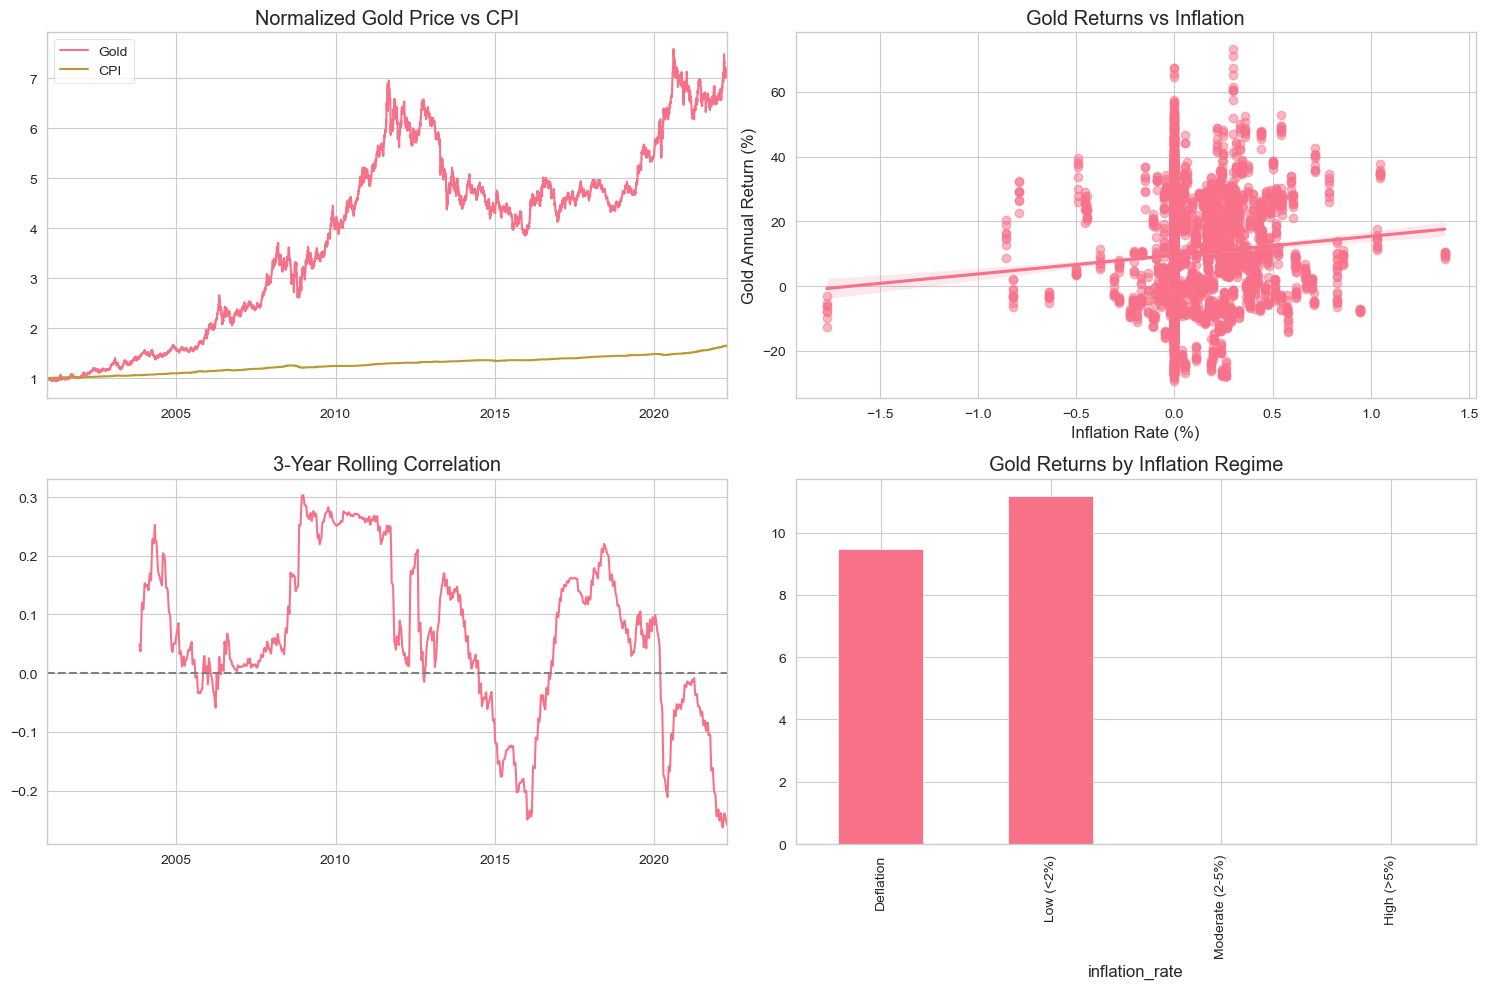


Key Statistics:
Correlation between gold and inflation: 0.081
Inflation beta: 5.824
Average gold return: 10.00%
Average inflation rate: 0.08%


In [4]:
# Run the analysis
if __name__ == "__main__":
    analyzer = GoldAnalysis()
    analyzer.analyze_relationship()

### Interpretation Summary:

- Gold does not consistently track inflation (low correlation).
- Gold reacts strongly when inflation spikes (high inflation beta).
- Gold has historically performed well overall (10% return), but not necessarily as an inflation hedge.

## Conclusion

While gold is often perceived as a safe-haven asset, this analysis suggests that it does not serve as a perfect inflation hedge in the short term. However, gold’s high inflation beta indicates that it may provide protection during extreme inflationary periods. Additionally, its historical long-term growth makes it a valuable asset in a diversified portfolio.

For investors seeking consistent inflation protection, alternative hedges such as inflation-linked bonds (TIPS), commodities, or diversified asset strategies may be worth exploring. However, gold remains an important asset for preserving purchasing power over extended periods.

#### Key Findings
- Weak Correlation (0.081): Gold and inflation have a low positive correlation, suggesting that gold prices do not consistently move in tandem with inflation.
- High Inflation Beta (5.824): Despite the weak correlation, gold tends to react strongly to inflation spikes, indicating that it may provide protection during periods of high inflation.
- Strong Long-Term Performance: Gold has delivered an average annual return of 10%, making it a valuable asset for wealth preservation, even if its relationship with inflation is inconsistent.